In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models import resnet50
import torch
from torch.utils.data import Dataset, DataLoader
# from ResNet import Bottleneck, ResNet, ResNet50
import pickle
import torch.nn.functional as F
from torch import nn
from torch.nn import init


c:\Users\Pc\miniconda3\envs\gait\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class BasicBlock(nn.Module):
    """Basic Block for resnet 18 and resnet 34
    """

    #BasicBlock and BottleNeck block
    #have different output size
    #we use class attribute expansion
    #to distinct
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        #the shortcut output dimension is not the same with residual function
        #use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.LeakyReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class BottleNeck(nn.Module):
    """Residual block for resnet over 50 layers
    """
    expansion = 2
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.LeakyReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=100):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True))
        #we use a different inputsize than the original paper
        #so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """make resnet layers(by layer i didnt mean this 'layer' was the
        same as a neuron netowork layer, ex. conv layer), one layer may
        contain more than one residual block
        Args:
            block: block type, basic block or bottle neck block
            out_channels: output depth channel number of this layer
            num_blocks: how many blocks per layer
            stride: the stride of the first block of this layer
        Return:
            return a resnet layer
        """

        # we have num_block blocks per layer, the first block
        # could be 1 or 2, other blocks would always be 1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = self.dropout(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output

def resnet18():
    """ return a ResNet 18 object
    """
    return ResNet(BasicBlock, [2, 2, 2, 2])

def resnet34():
    """ return a ResNet 34 object
    """
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    """ return a ResNet 50 object
    """
    return ResNet(BottleNeck, [3, 4, 6, 3])

def resnet101():
    """ return a ResNet 101 object
    """
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    """ return a ResNet 152 object
    """
    return ResNet(BottleNeck, [3, 8, 36, 3])

In [3]:
import torch

# Check if a GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the device to allow for dynamic GPU memory growth
torch.backends.cudnn.benchmark = True

# You can print the device to verify if it's using GPU or CPU
print(f"Using device: {device}")


Using device: cuda


In [4]:
BATCH_SIZE = 4

In [5]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict



train = unpickle('./cifar-100-python/train')
print(train.keys())

data =    train[b'data']
filenames = train[b'filenames']
batch_label = train[b'batch_label']
fine_labels =    train[b'fine_labels']
coarse_labels = train[b'coarse_labels']




dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])


In [6]:
print(len(filenames))
print(len(batch_label))
print(len(fine_labels))
print(len(coarse_labels))

print(filenames[0])
print(batch_label[0])
print(fine_labels[0])
print(coarse_labels[0])


print(set(fine_labels))
print(set(batch_label))
print(set(coarse_labels))

50000
21
50000
50000
b'bos_taurus_s_000507.png'
116
19
11
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}
{32, 97, 98, 99, 102, 103, 104, 105, 110, 111, 49, 114, 116}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}


(32, 32, 3)
uint8


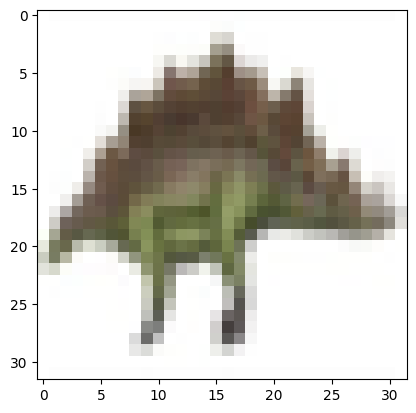

b'stegosaurus_s_000125.png'
29


In [7]:


def show_image(image):

    image  = np.transpose(np.reshape(image, (3, 32, 32)), (1, 2, 0))
    print(image.shape)
    print(image.dtype)
    plt.imshow(image)
    plt.show()

show_image(data[1])

print(filenames[1])
print(fine_labels[1])

In [8]:
# net = resnet50(pretrained='imagenet')
# # net = resnet50(pretrained='IMAGENET1K_V2')
# Modify the last fully connected layer
# num_features = net.fc.in_features  # Get the number of input features for the last FC layer
# new_fc_layer = nn.Linear(num_features, 100)  # Create a new FC layer with 100 output units

# Replace the last FC layer in the ResNet-50 model
# net.fc = new_fc_layer
# net = ResNet50(100)
net = resnet50()
# Optionally, you can also add a softmax layer if your problem is a classification task
# net.add_module('softmax', nn.Softmax(dim=1))

# Print the modified ResNet-50 architecture
print(net)
total_params = sum(p.numel() for p in net.parameters())
print(total_params)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (conv2_x): Sequential(
    (0): BottleNeck(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): LeakyReLU(negative_slope=0.01, inplace=True)
        (6): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
     

In [9]:
# model.eval()
# checkpoint_path = './checkpoint.pth'
# torch.save(model.state_dict(), checkpoint_path) 

In [10]:
# output = model(torch.randn(1, 3, 32, 32))
# print(output.shape)


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ChannelAttention(nn.Module):
    def __init__(self,channel,reduction=16):
        super().__init__()
        self.maxpool=nn.AdaptiveMaxPool2d(1)
        self.avgpool=nn.AdaptiveAvgPool2d(1)
        self.se=nn.Sequential(
            nn.Conv2d(channel,channel//reduction,1,bias=False),
            nn.ReLU(),
            nn.Conv2d(channel//reduction,channel,1,bias=False)
        )
        self.sigmoid=nn.Sigmoid()
    
    def forward(self, x) :
        max_result=self.maxpool(x)
        avg_result=self.avgpool(x)
        max_out=self.se(max_result)
        avg_out=self.se(avg_result)
        output=self.sigmoid(max_out+avg_out)
        return output

class SpatialAttention(nn.Module):
    def __init__(self,kernel_size=7):
        super().__init__()
        self.conv=nn.Conv2d(2,1,kernel_size=kernel_size,padding=kernel_size//2)
        self.sigmoid=nn.Sigmoid()
    
    def forward(self, x) :
        max_result,_=torch.max(x,dim=1,keepdim=True)
        avg_result=torch.mean(x,dim=1,keepdim=True)
        result=torch.cat([max_result,avg_result],1)
        output=self.conv(result)
        output=self.sigmoid(output)
        return output



class CBAMBlock(nn.Module):

    def __init__(self, channel=512,reduction=16,kernel_size=16):
        super().__init__()
        self.ca=ChannelAttention(channel=channel,reduction=reduction)
        self.sa=SpatialAttention(kernel_size=kernel_size)


    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        b, c, _, _ = x.size()
        residual=x
        out=x*self.ca(x)
        out=out*self.sa(out)
        return out+residual




class CifarClassification(nn.Module):
    def __init__(self):
        super(CifarClassification, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.convtrans = nn.ConvTranspose2d(32, 32, kernel_size=3, padding=1, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.maxpool3 = nn.MaxPool2d(2, 2)
        self.cbam=CBAMBlock(channel=32,reduction=16 , kernel_size=49 )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(12544, 512)
        # self.fc1 = nn.Linear(256 * 4 * 4, 512)
        # self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 100)
        
    def forward(self, xb):
        x = F.relu(self.conv1(xb))
        x = self.convtrans(x)
        # print(x.shape)
        x=self.cbam(x)
        # print(x.shape)
        # print(x.shape)
        x = F.relu(self.conv2(x))
        x = self.maxpool1(x)
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool2(x)
        
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.maxpool3(x)
        
        x = self.flatten(x)
        # print(x.shape)
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

# Instantiate the model

# Example usage:
# input_tensor = torch.randn(1, 3, 32, 32)  # Example input with shape (batch_size, channels, height, width)
# output_tensor = model(input_tensor)


In [12]:

# net = ResNet50(100)
# net = CifarClassification()

# Count the total, trainable, and non-trainable parameters
total_params = sum(p.numel() for p in net.parameters())
trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
non_trainable_params = total_params - trainable_params

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")
print(f"Non-trainable Parameters: {non_trainable_params}")
net.eval()

# checkpoint_path = './checkpoint.pth'
# pretrained_resnet = torch.load('checkpoint.pth')

# net.load_state_dict(pretrained_resnet)

Total Parameters: 16833700
Trainable Parameters: 16833700
Non-trainable Parameters: 0


ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (conv2_x): Sequential(
    (0): BottleNeck(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): LeakyReLU(negative_slope=0.01, inplace=True)
        (6): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
     

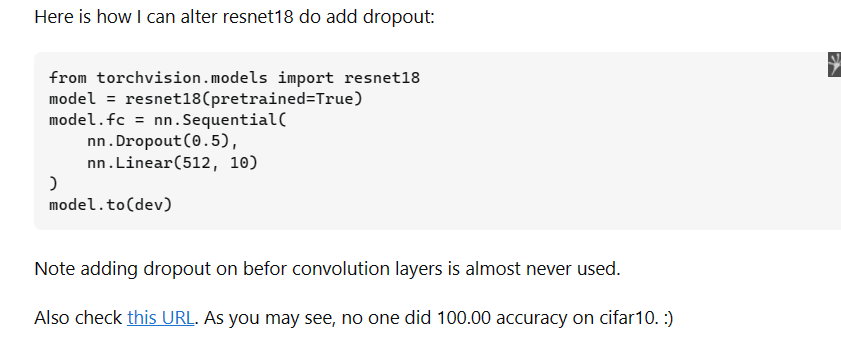

In [13]:
with torch.no_grad():
    # x = torch.ones(4*3*16*128*44).reshape(4,3,16,128,44)
    x = torch.ones(3 * 3 * 32 * 32).reshape(3, 3, 32, 32)
    # a = Variable(a.cuda)
    print('x=', x.shape)
    # a,b = net(x)
    # print('a,b=',a.shape,b.shape)
    # a,_ = net(x)
    outputs = net(x)
    # n,_,_ = outputs.size()
    print('a,b=', outputs.shape)

x= torch.Size([3, 3, 32, 32])
a,b= torch.Size([3, 100])


## Load Dataset

c:\Users\Pc\miniconda3\envs\gait\lib\site-packages\torchvision\transforms\transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


torch.Size([4, 3, 224, 224]) torch.Size([4])
tensor(22)


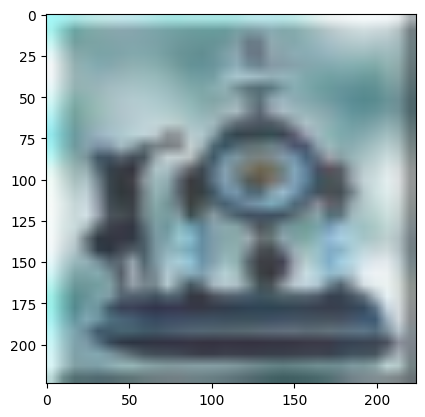

In [14]:
from PIL import Image

from torchvision import transforms
image_transform = transforms.Compose([

        # transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
          # 
          # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.Resize((224, 224), interpolation=Image.BILINEAR),        # transforms.Lambda(lambda x: x / 255.0)  # Normalize by dividing by 255
        # transforms.Normalize(mean=[x / 255.0 for x in[0.507, 0.487, 0.441]],std=[x / 255.0 for x in [0.267, 0.256, 0.276]])
        #   transforms.Normalize((value,), (value,))
])


class VideoDataset(Dataset):
    def __init__(self, dir, transform=None):

        self.dir= dir
        self.transform = transform
        data = unpickle(dir)
        self.filenames = data[b'filenames']
        self.images =    data[b'data']
        self.labels =    data[b'fine_labels']


    
    def unpickle(file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        # print(image.shape)
        image  = np.reshape(image, (3, 32, 32))
        image =  np.transpose(image , (1, 2, 0))
        # print(image.shape)
        # print(image.shape)
        label = self.labels[idx]
        # image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        # convert image and label to float 
        
        # print("------------",image.shape)
        return image, label 
        # return torch.from_numpy(image), label 
        # return torch.from_numpy(image), label , self.filenames[idx]

train_dataset = VideoDataset('./cifar-100-python/train' , transform=image_transform)
train_dataset = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = VideoDataset('./cifar-100-python/test' , transform=image_transform)
test_dataset = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


for i , (image, label) in enumerate(train_dataset):
    print(image.shape, label.shape)
    plt.imshow(image[0].numpy().transpose(1, 2, 0))
    print(label[0])
    # print(filenames[0])
    break

In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
print(device)

#to send the data to GPU--------------------
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
#TO make data loader when load the data automatically move the data to device 
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)



train_dataset  = DeviceDataLoader(train_dataset, device)
test_dataset  = DeviceDataLoader(test_dataset, device)
to_device(net , device)

cuda


ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (conv2_x): Sequential(
    (0): BottleNeck(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): LeakyReLU(negative_slope=0.01, inplace=True)
        (6): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
     

In [16]:
import torch
import torch.nn.functional as F

# Function for element-wise comparison between predicted index and labels
def accuracy(outputs, labels):
    _, pred = torch.max(outputs, dim=1)
    acc = torch.sum(pred == labels).item() / len(pred)
    return torch.tensor(acc)

# Training loop
def train(model, loader, optimizer):
    images, labels = loader
    out = model(images)
    loss = F.cross_entropy(out, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()

# Validation function
def validation(model, loader):
    with torch.no_grad():
        images, labels = loader
        out = model(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
    return {'val_acc': acc, 'val_loss': loss.item()}

# # Validation epoch end function
# def validation_epoch_end(outputs):
#     batch_losses = [x['val_loss'] for x in outputs]
#     epoch_loss = torch.stack(batch_losses).mean()
#     batch_accs = [x['val_acc'] for x in outputs]
#     epoch_acc = torch.stack(batch_accs).mean()
#     return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
def validation_epoch_end(outputs):
    batch_losses = [torch.tensor(x['val_loss']) for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [torch.tensor(x['val_acc']) for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}


# Epoch end function
def epoch_end(epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['train_loss'], result['val_loss'], result['val_acc']))

# Evaluator function
def evaluator(model, val_loader):
    outputs = [validation(model, batch) for batch in val_loader]
    return validation_epoch_end(outputs)

# Training process
def fit(model, num_epochs, train_loader, val_loader, learning_rate, optimizer=torch.optim.Adam):
    history = []
    optimizer_define = optimizer(model.parameters(), learning_rate)
    train_losses = []
    best_val_acc = 0.0  # Variable to keep track of the best validation accuracym
    best_weights = None  # Variable to store the best model weights

    for epoch in range(num_epochs):
        i = 0
        model.train()
        for each_loader in train_loader:
            i = i + 1
            loss = train(model, each_loader, optimizer_define)
            train_losses.append(torch.tensor(loss))
            if i % 3000 == 0:
                print(f"Epoch: {epoch} loss  {i}/{len(train_loader)}", loss)
        model.eval()
        result = evaluator(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        epoch_end(epoch, result)
        history.append(result)
        if result['val_acc'] > best_val_acc:
            best_val_acc = result['val_acc']
            print(f"Saving the best model {best_val_acc}")
            checkpoint_path = './checkpoint2.pth'
            torch.save(net.state_dict(), checkpoint_path)
            
    return history


torch.Size([4, 3, 224, 224]) torch.Size([4])
tensor(54, device='cuda:0')


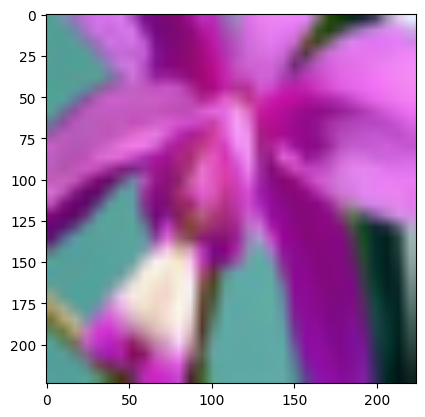

In [17]:
for i , (image, label) in enumerate(train_dataset):
    i = 1
    print(image.shape, label.shape)
    plt.imshow(image[i].cpu().numpy().transpose(1, 2, 0))
    print(label[i])
    # print(filenames[0])
    break

In [18]:
# checkpoint_path = './checkpoint.pth'
# weights = torch.load(checkpoint_path)
# # torch.save(net.state_dict(), checkpoint_path)
# net.load_state_dict(weights)

In [19]:
print(len(train_dataset))

12500


In [20]:
# net.train()
history = fit(net, 200, train_dataset, test_dataset, 0.001 )

KeyboardInterrupt: 

In [ ]:
checkpoint_path = './checkpoint.pth'
torch.save(net.state_dict(), checkpoint_path)

In [ ]:
print("Training Cost: 0.5776")
print("Test Cost: 0.4621")

Training Cost: 0.5776
Test Cost: 0.4621
